# Exponential Disc

In [1]:
import sys
import numpy as np
import torch
import matplotlib.pyplot as plt
from pyDOE import lhs

sys.path.append('../')
from gpinn.network import FCN
from gpinn.training import TrainingPhase

As a reminder, the equation we want to solve is the following :

$$ \dfrac{1}{R'} \dfrac{\partial}{\partial R'} \left(R' \dfrac{\partial \Phi'}{\partial R'}\right) + \dfrac{1}{\eta^{2}}\dfrac{\partial^2 \Phi'}{\partial z'^2} = e^{-R'} \cosh^{-2}{z'}$$

where we have defined : $\phi'= \frac{\phi}{G M_d/z_d}$, $z' = \dfrac{z}{z_d}$, $R' = \dfrac{R}{R_d}$and $\eta = \frac{z_d}{R_d} $.

Therefore the residual would be written as follows:
$$\dfrac{1}{R'} \dfrac{\partial}{\partial R'} \left(R' \dfrac{\partial \Phi'}{\partial R'}\right) + \dfrac{1}{\eta^{2}}\dfrac{\partial^2 \Phi'}{\partial z'^2} - e^{-R_i'} \cosh^{-2}{z_i'}$$

and the loss function for the collocation points:
$$ \mathcal{L}_{\mathcal{F}}(\theta) = MSE_{\mathcal{F}} = \dfrac{1}{N_c}\sum_{i=1}^{N_c}\left\|\dfrac{1}{R'} \dfrac{\partial}{\partial R'} \left(R' \dfrac{\partial \Phi'}{\partial R'}\right) + \dfrac{1}{\eta^{2}}\dfrac{\partial^2 \Phi'}{\partial z'^2} - e^{-R_i'} \cosh^{-2}{z_i'}\right\|^2$$

$z_d$, for now, we will set it in order to have $\dfrac{z_d}{R_d}=0.2$

The domain where to solve the equations can be between $\dfrac{R}{R_d} = [0;20]$  and $\dfrac{z}{z_d} = [0;5]$

We should also investigate where and when is possible to solve the equation via approximations.

To compare our results, we set here :
- $R_d = 4$  
- $\dfrac{z_d}{R_d}=0.2$  
- $M_d = 10^{10.5}$   

In [2]:
Rd = 4
eta = 0.2
zd = Rd * eta
Md = 10**10.5

In [3]:
def pde_residual(nn, x_pde):
    r, z = x_pde[:, 0].unsqueeze(1), x_pde[:, 1].unsqueeze(1)
    x_pde.requires_grad = True 
    f = nn(x_pde)
    # -------- Differentiation w.r.t. R ----------------
    f_rz = torch.autograd.grad(f, x_pde, torch.ones(x_pde.shape[0], 1),retain_graph=True, create_graph=True)[0]
    f_r = f_rz[:, 0].unsqueeze(1)
    f_r = f_r * r
    f_rrz = torch.autograd.grad(f_r, x_pde, torch.ones(x_pde.shape[0], 1), retain_graph=True, create_graph=True)[0]
    f_rr = f_rrz[:, 0].unsqueeze(1)
    # -------- Differentiation w.r.t. z ----------------
    f_z = f_rz[:, 1].unsqueeze(1)
    f_zzr = torch.autograd.grad(f_z, x_pde, torch.ones(x_pde.shape[0], 1), retain_graph=True, create_graph=True)[0]
    f_zz = f_zzr[:, 1].unsqueeze(1)
    
    lhs = 1/r * f_rr + 1/eta**2 * f_zz
    rhs = torch.exp(-r) * torch.cosh(z)**(-2)
    return lhs - rhs

In [4]:
def mse(residual: torch.Tensor):
    return residual.pow(2).mean()

def rmse(residual: torch.Tensor):
    return torch.sqrt(residual.pow(2).mean())

def mae(array: torch.Tensor):
    return torch.abs(array).mean()

## Parameters

In [5]:
# To generate new data:
z_min = 0
z_max = 4
r_min = 0
r_max = 80
total_points_z = 250
total_points_r = 250
# Nu: Number of training points # Nf: Number of collocation points (Evaluate PDE)
Nu = 296
Nf = 1024

## Data Generation

In [6]:
z = torch.linspace(z_min, z_max, total_points_z).view(-1, 1)/zd
r = torch.linspace(r_min, r_max, total_points_r).view(-1, 1)/Rd
R, Z = torch.meshgrid(r.squeeze(1), z.squeeze(1), indexing='xy')

**Note:** To evaluate the potential $\Phi(R, z)$ on the boundaries, we first need to interpolate it from the data acquired during previous simulations. 

In [7]:
from scipy.interpolate import RegularGridInterpolator

def load_data(reshape=True, scaled=False):
    data = np.loadtxt("test_phi_grid.dat")
    R_test, z_test, phi_test = data.T
    if scaled:
        phi_test /= (10**(10.5)/zd)
    if reshape:
        return R_test.reshape(250, 250), z_test.reshape(250, 250), phi_test.reshape(250, 250)
    
    return R_test, z_test, phi_test
    
def phi_inter(R, z, scaled=True):
    Md = 1
    _r, _z, _phi = load_data(reshape=True)
    _r /= Rd
    _z /= zd
    _phi *= zd
    f = RegularGridInterpolator((np.ascontiguousarray(_r[:, 0]), np.ascontiguousarray(_z[0, :])), np.ascontiguousarray(_phi))
    if scaled:
        Md = 10**(10.5)
    return torch.Tensor(f((R, z)) / Md)

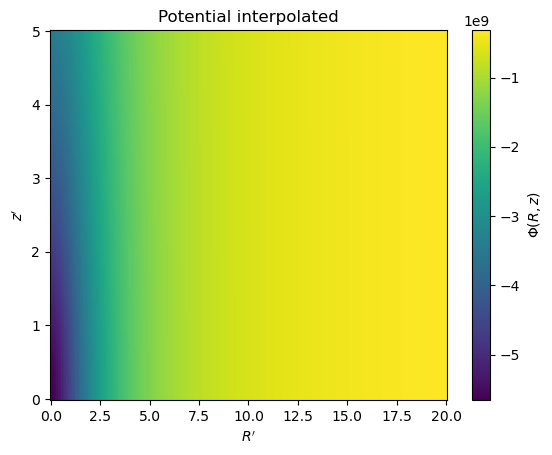

In [8]:
plt.figure()
plt.title('Potential interpolated')
plt.pcolormesh(R, Z, phi_inter(R, Z, scaled=False))
plt.xlabel("$R'$")
plt.ylabel("$z'$")
plt.colorbar(label="$\Phi(R, z)$");

## Boundary Conditions

In [9]:
def plot_boundary_pot(phi_train, phi_th, x_min, x_max, n_points, *, border, r, z):
    x_plot = np.linspace(x_min, x_max, n_points)
    phi_train = np.abs(phi_train)
    phi_th = np.abs(phi_th)
    plt.figure()
    plt.title(f"Potential on {border} border")
    plt.plot(x_plot, phi_train, label="Training Data")
    plt.plot(np.linspace(x_min, x_max, 250), phi_th, label="Pre-Computed potential")
    plt.plot(x_plot[phi_train.argmax()], phi_train.max(), marker='x', color='red', label=f'$\Phi=${phi_train.max(): .3f}')
    plt.plot(x_plot[phi_train.argmin()], phi_train.min(), marker='x', color='green', label=f'$\Phi=${phi_train.min(): .3f}')
    plt.xlabel('$z$')
    plt.ylabel(f'$\Phi({r}, {z})$')
    plt.yscale('log')
    plt.legend();

In [10]:
_, _, phi_scaled = load_data(scaled=True)

### Left Boundary

Corresponds to $R'=0$ and $z' \in [0, 5]$.

In [11]:
left_X = torch.hstack((R[:, 0][:, None], Z[:, 0][:, None]))
left_Y = phi_inter(left_X[:, 0], Z[:, 0]).unsqueeze(1)

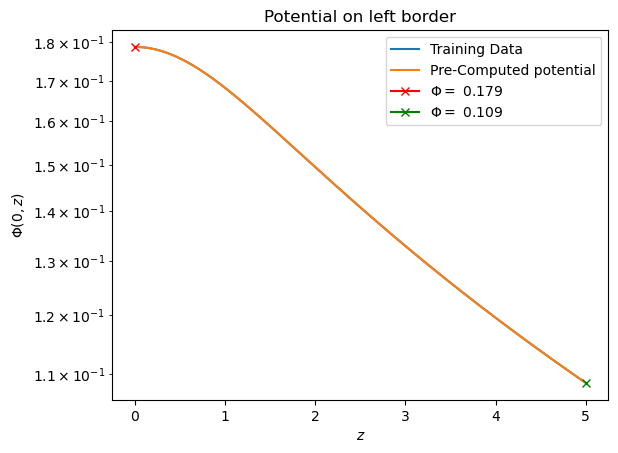

In [12]:
plot_boundary_pot(left_Y, phi_scaled[0, :], z_min/zd, z_max/zd, total_points_z, border='left', r=0, z='z');

### Bottom Boundary 

Corresponds to $R'\in [0, 20]$ and $z' = 0$.

In [13]:
bottom_X = torch.hstack((R[0, :][:, None], Z[0, :][:, None]))
bottom_Y = phi_inter(bottom_X[:, 0], Z[0, :]).unsqueeze(1)

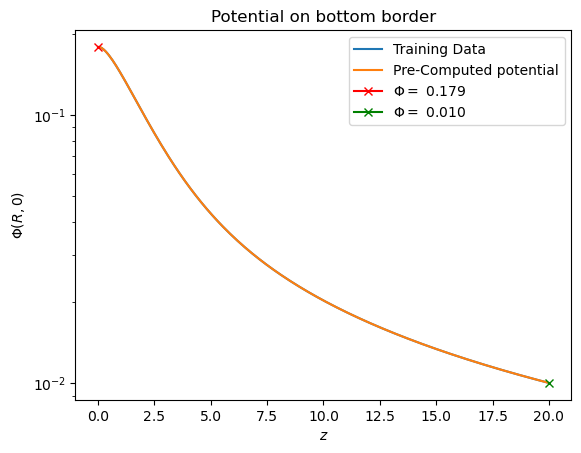

In [14]:
plot_boundary_pot(bottom_Y, phi_scaled[:, 0], r_min/Rd, r_max/Rd, total_points_r, border='bottom', r='R', z=0);

### Top Boundary

Corresponds to $R'\in [0, 20]$ and $z' = 5$.

In [15]:
top_X = torch.hstack((R[-1, :][:, None], Z[-1, :][:, None]))
top_Y = phi_inter(top_X[:, 0], Z[-1, :]).unsqueeze(1)

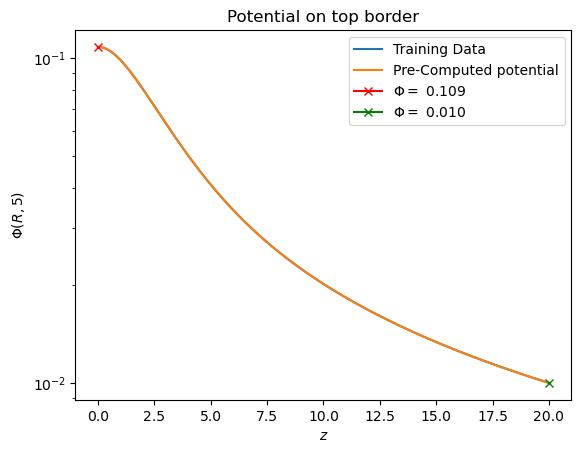

In [16]:
plot_boundary_pot(top_Y, phi_scaled[:, -1], r_min/Rd, r_max/Rd, total_points_r, border='top', r='R', z=5);

### Right Boundary

Corresponds to $R'=20$ and $z' \in [0, 5]$.

In [17]:
right_X = torch.hstack((R[:, -1][:, None], Z[:, -1][:, None]))
right_Y = phi_inter(right_X[:, 0], Z[:, 0]).unsqueeze(1)

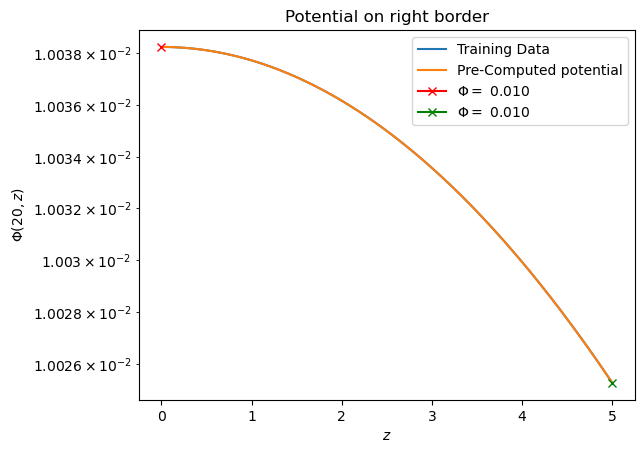

In [18]:
plot_boundary_pot(right_Y, phi_scaled[-1, :], z_min/zd, z_max/zd, total_points_z, border='right', r=20, z='z');

### Testing Data

In [19]:
z_val = torch.linspace(z_min+0.1, z_max-0.1, total_points_z//3).view(-1, 1)/zd
r_val = torch.linspace(r_min+0.1, r_max-0.1, total_points_r//3).view(-1, 1)/Rd
R_val, Z_val = torch.meshgrid(r_val.squeeze(1), z_val.squeeze(1), indexing='xy')

In [20]:
# Transform the mesh into a 2-column vector
lb_val = torch.Tensor([r_val[0], z_val[0]])
ub_val = torch.Tensor([r_val[-1], z_val[-1]])

X_val = lb_val + (ub_val - lb_val) * lhs(2, Nf//3)
Y_val = phi_inter(X_val[:, 0], X_val[:, 1]).unsqueeze(1)

In [21]:
y_real = phi_inter(R, Z)
x_test = torch.hstack((R.transpose(1, 0).flatten()[:, None], Z.transpose(1, 0).flatten()[:, None]))
y_test = y_real.transpose(1, 0).flatten()[:, None]  # Colum major Flatten (so we transpose it)
# Domain bounds
lb = x_test[0]  # first value
ub = x_test[-1]  # last value

### Training Data

In [22]:
X_train = torch.vstack([left_X, bottom_X, top_X, right_X])
Y_train = torch.vstack([left_Y, bottom_Y, top_Y, right_Y])
# Choose(Nu) points of our available training data:
idx = np.random.choice(X_train.shape[0], Nu, replace=False)
X_train_Nu = X_train[idx, :]
Y_train_Nu = Y_train[idx, :]
# Collocation Points (Evaluate our PDe)
# Choose(Nf) points(Latin hypercube)
lb = torch.Tensor([r[0], z[0]])
ub = torch.Tensor([r[-1], z[-1]])
X_train_Nf = lb + (ub - lb) * lhs(2, Nf)  # 2 as the inputs are x and gamma

# X_train_Nf = torch.vstack((X_train_Nf, X_train_Nu))  # Add the training points to the collocation point

### Initial Points

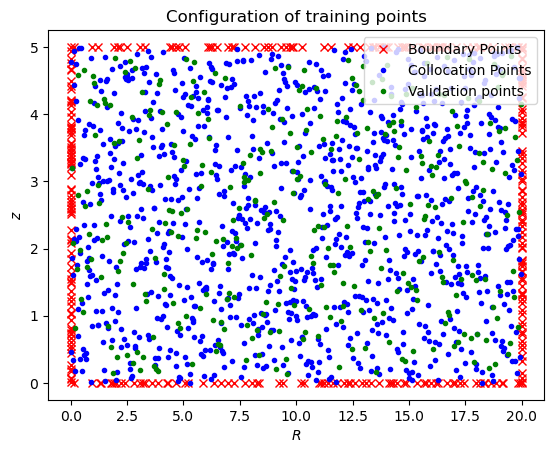

In [23]:
plt.figure()
plt.title("Configuration of training points")
plt.plot(X_train_Nu[:, 0], X_train_Nu[:, 1], 'xr', label="Boundary Points")
plt.plot(X_train_Nf[:, 0], X_train_Nf[:, 1], '.b', label="Collocation Points")
plt.plot(X_val[:, 0], X_val[:, 1], '.g', label="Validation points")
plt.xlabel('$R$')
plt.ylabel('$z$')
plt.legend(loc='upper right')
plt.show()

## Creating the model

Tuning of hyper-parameters has been done, we can load the best parameters as follows:

In [24]:
import sqlite3

def read_sorted_results(database_file):
    conn = sqlite3.connect(database_file)
    cursor = conn.cursor()
    
    query = "SELECT * FROM results ORDER BY accuracy ASC"
    cursor.execute(query)
    
    results = cursor.fetchall()
    
    conn.close()
    
    return results

def read_model_details(model_name):
    with open(f"../tuning/{model_name}.txt") as f:
        data = f.read()
    return data

In [66]:
# Exemple d'utilisation :
database_file = '../results.db'
sorted_results = read_sorted_results(database_file)

nth_result = 1
print(f"{nth_result+1}th result with smallest average relative error:", sorted_results[nth_result])

model_details = read_model_details(sorted_results[nth_result][1])

print(model_details)

2th result with smallest average relative error: (168, 'silu564mse1e-6', 0.002269907621666789)

Layers: [ 2 64 64 64 64 64  1]
Activation: SiLU()
Error function: mse
Learning rate: 1e-06
----------------------------
Max accuracy: 0.002269907621666789
Reached at epoch: 3285/10000
Model reference: silu564mse1e-6


### Training

In [67]:
# Create Model

steps = 10_000

layers = np.array([2, 64, 64, 64, 64, 64, 1])

PINN = FCN(layers, act=torch.nn.SiLU())

print(PINN)

training = TrainingPhase(neural_net=PINN, training_points=(X_train_Nu, Y_train_Nu, X_train_Nf),
                         testing_points=(X_val, Y_val), equation=pde_residual, n_epochs=steps,
                         _loss_function=mse)


net, epochs, train_losses, val_losses, accuracies = training.train_model(optimizer=torch.optim.Adam, learning_rate=1e-6)

FCN(
  (activation): SiLU()
  (linears): ModuleList(
    (0): Linear(in_features=2, out_features=64, bias=True)
    (1-4): 4 x Linear(in_features=64, out_features=64, bias=True)
    (5): Linear(in_features=64, out_features=1, bias=True)
  )
)


100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [03:22<00:00, 49.40it/s]


In [ ]:
np.save("../arrays/loss_disc.npy", train_losses)
np.save("../arrays/epochs_disc.npy", epochs)
training.save_model("../models/exp_disc.pt")

### Training Results

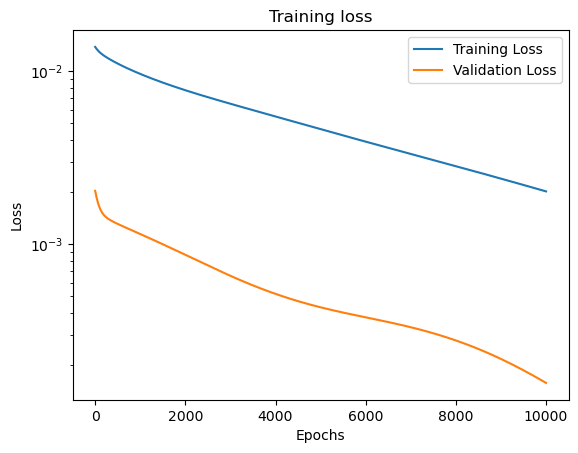

In [68]:
plt.figure()
plt.title('Training loss')
plt.plot(epochs, train_losses, label="Training Loss")
plt.plot(epochs, val_losses, label="Validation Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.yscale('log');

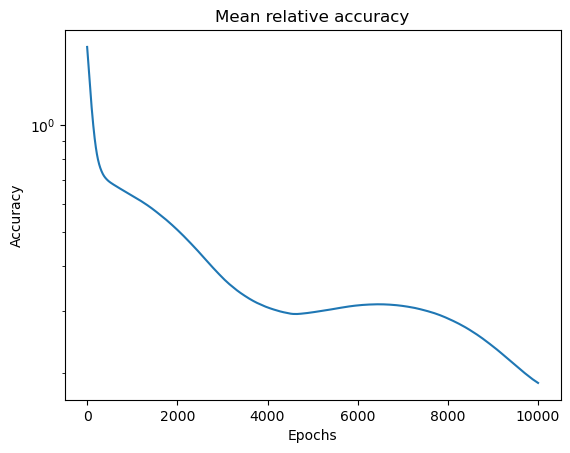

In [69]:
plt.figure()
plt.title("Mean relative accuracy")
plt.plot(epochs, np.abs(accuracies), label="Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.yscale('log');

### Comparing Results

### Testing on a $[0, 20] \times [0, 5]$ domain

In [70]:
R_test, z_test, phi_test = load_data(scaled=True, reshape=True)
R_test /= Rd
z_test /= zd

In [71]:
input_matrix = np.array([R_test.flatten(), z_test.flatten()]).T
phi_pred = net(input_matrix).detach().numpy().reshape(250, 250)

In [72]:
diff = phi_test - phi_pred
vmin, vmax = np.percentile(diff, (5, 95))

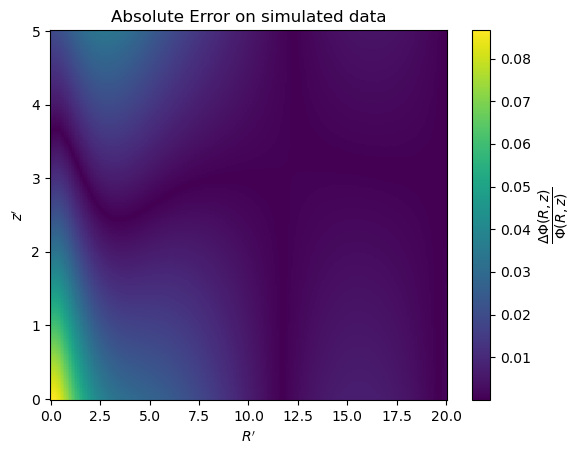

In [73]:
plt.figure()
plt.title("Absolute Error on simulated data")
plt.pcolormesh(R_test, z_test, np.abs(diff))
plt.xlabel("$R'$")
plt.ylabel("$z'$")
plt.colorbar(label="$\dfrac{\Delta \Phi(R, z)}{\Phi(R, z)}$");

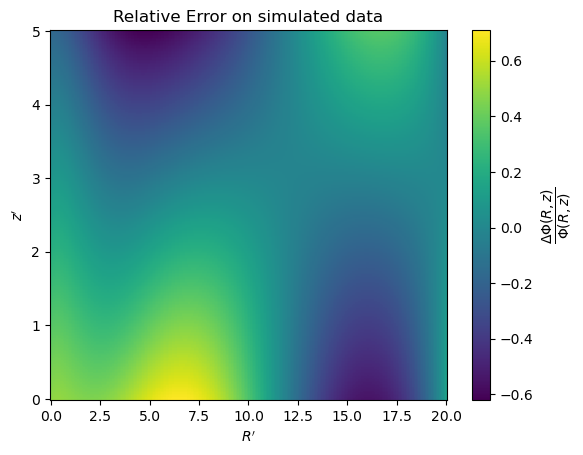

In [74]:
plt.figure()
plt.title("Relative Error on simulated data")
plt.pcolormesh(R_test, z_test, diff/phi_test)
plt.xlabel("$R'$")
plt.ylabel("$z'$")
plt.colorbar(label="$\dfrac{\Delta \Phi(R, z)}{\Phi(R, z)}$");
#plt.clim(vmin=vmin, vmax=vmax);

In [75]:
print(f"Max relative error: {float((diff/phi_test).max()): %}")
print(f"Average relative error: {float(np.abs((diff/phi_test)).mean()): %}")

Max relative error:  70.940853%
Average relative error:  19.972450%


We have tested the unscaled PINN on the data used for the interpolation. Just to make sure everything works as expected let us test the result on a domain for which we are sure the points haven't been seen. 

In [76]:
n_points = 500
R_test = np.linspace(0, 80, n_points)/Rd
z_test = np.linspace(0, 4, n_points)/zd
R_test, z_test = np.meshgrid(R_test, z_test, indexing='ij')
phi_test = phi_inter(R_test, z_test)

In [77]:
input_matrix = np.array([R_test.flatten(), z_test.flatten()]).T
phi_pred = net(input_matrix).detach().numpy().reshape(n_points, n_points)

In [78]:
diff = phi_test - phi_pred
vmin, vmax = np.percentile(diff, (5, 95))

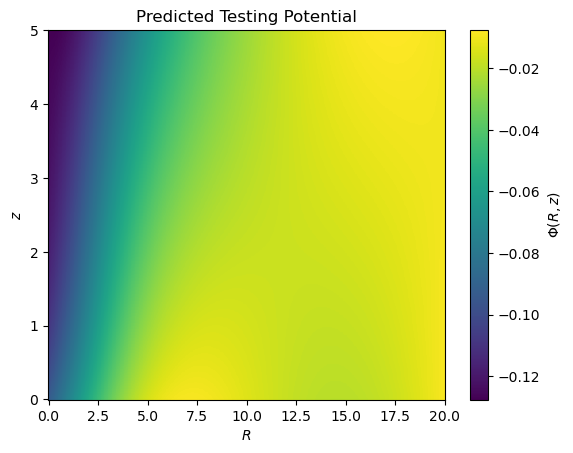

In [79]:
plt.figure()
plt.title("Predicted Testing Potential")
plt.pcolormesh(R_test, z_test, phi_pred)
plt.xlabel("$R$")
plt.ylabel("$z$")
plt.colorbar(label="$\Phi(R, z)$");

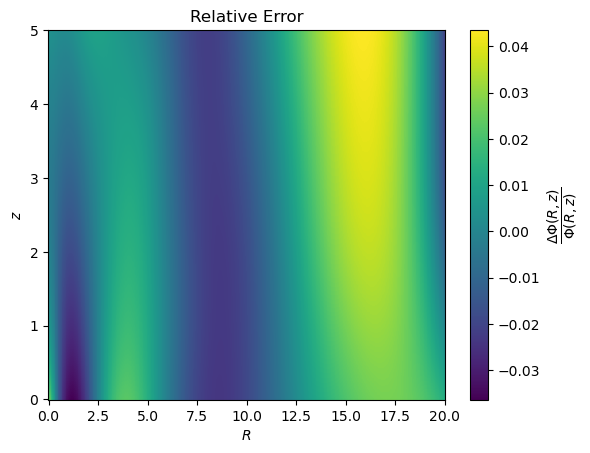

In [39]:
plt.figure()
plt.title("Relative Error")
plt.pcolormesh(R_test, z_test, diff/phi_test)
plt.xlabel("$R$")
plt.ylabel("$z$")
plt.colorbar(label="$\dfrac{\Delta \Phi(R, z)}{\Phi(R, z)}$");

In [40]:
print(f"Max relative error: {float((diff/phi_test).max()): %}")
print(f"Average relative error: {float(np.abs((diff/phi_test)).mean()): %}")

Max relative error:  4.353443%
Average relative error:  1.647182%


We now wish to give it back the right dimensions by multiplying the mass $M=10^{10.5}$

In [41]:
n_points = 500
R_test = np.linspace(0, 80, n_points)/Rd
z_test = np.linspace(0, 4, n_points)/zd
R_test, z_test = np.meshgrid(R_test, z_test, indexing='ij')
phi_test = phi_inter(R_test, z_test) * Md

In [42]:
input_matrix = np.array([R_test.flatten(), z_test.flatten()]).T
phi_pred = net(input_matrix).detach().numpy().reshape(n_points, n_points) * Md

In [43]:
diff = phi_test - phi_pred
vmin, vmax = np.percentile(diff, (5, 95))

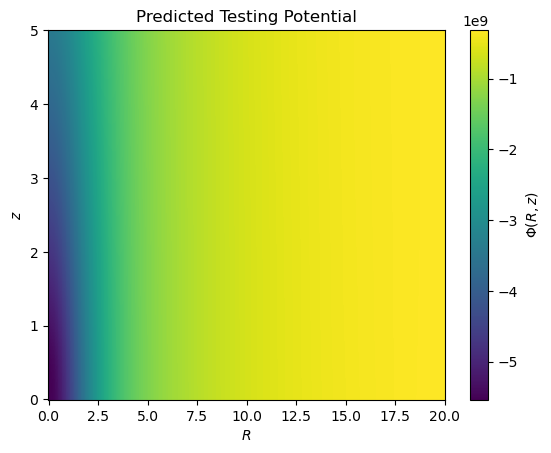

In [44]:
plt.figure()
plt.title("Predicted Testing Potential")
plt.pcolormesh(R_test, z_test, phi_pred)
plt.xlabel("$R$")
plt.ylabel("$z$")
plt.colorbar(label="$\Phi(R, z)$");

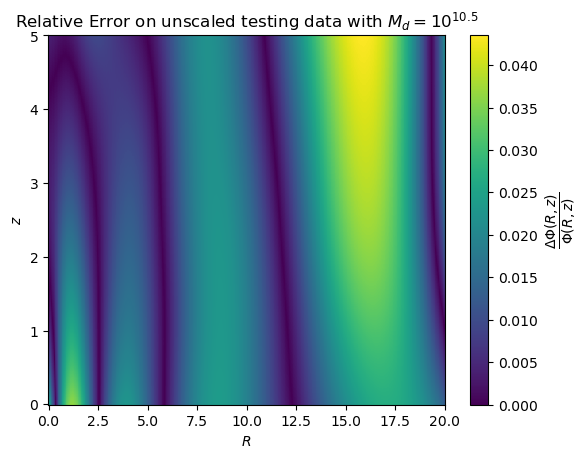

In [45]:
plt.figure()
plt.title("Relative Error on unscaled testing data with $M_d=10^{10.5}$")
plt.pcolormesh(R_test, z_test, np.abs(diff/phi_test))
plt.xlabel("$R$")
plt.ylabel("$z$")
plt.colorbar(label="$\dfrac{\Delta \Phi(R, z)}{\Phi(R, z)}$");

In [46]:
relative_error = np.abs(diff/phi_test).flatten()
print("Mean relative error :", np.mean(relative_error.numpy()))

Mean relative error : 0.016471814


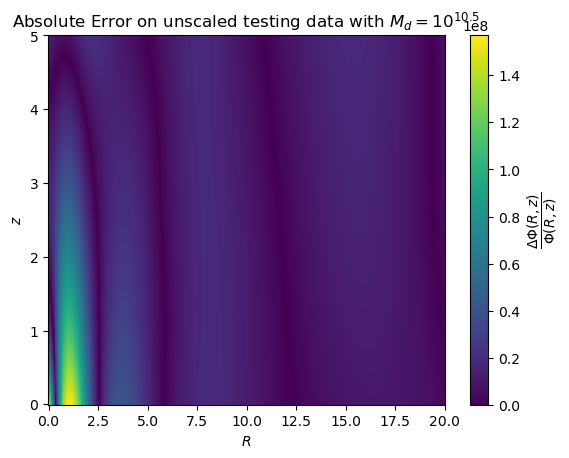

In [47]:
plt.figure()
plt.title("Absolute Error on unscaled testing data with $M_d=10^{10.5}$")
plt.pcolormesh(R_test, z_test, np.abs(diff))
plt.xlabel("$R$")
plt.ylabel("$z$")
plt.colorbar(label="$\dfrac{\Delta \Phi(R, z)}{\Phi(R, z)}$");

In [48]:
absolute_error = np.abs(diff).flatten()
print("Mean absolute error :", np.mean(absolute_error.numpy()))

Mean absolute error : 14135371.0
